## react agent

In [2]:
! pip install langgraph langsmith langchain-openai

In [4]:
import os
from langchain_openai import ChatOpenAI
from typing import Literal
from langchain_core.tools import tool
from IPython.display import Image, display
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState



os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "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"
# LangSmith 项目名称，默认 default
os.environ["LANGCHAIN_PROJECT"] = "default"

In [5]:
@tool
def get_deployment(deplyment_name: str):
    """Use this to get deployment YAML."""
    print("get deployment: ", deplyment_name)
    return """
apiVersion: apps/v1
kind: Deployment
metadata:
  name: payment
spec:
  selector:
    matchLabels:
    app: payment
  template:
    metadata:
    labels:
      app: payment
    spec:
      containers:
      - name: payment
        image: nginx
        ports:
          - containerPort: 80
"""

@tool
def apply_deployment(patch_json: str):
    """Edit the deployment YAML."""
    print("apply deployment: ", patch_json)
    # 这里在后续的课程里会讲解调用 k8s API 来真正部署 patch_json
    return "deployment applied"

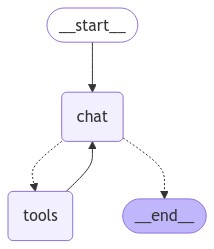

In [9]:
tools = [get_deployment, apply_deployment]
model_with_tools = ChatOpenAI(
    model="gpt-4o",
    api_key="sk-T6SlqfUnyFytejvA3c1584F87d6343878232185e26243b1d",
    base_url="https://api.apiyi.com/v1",
    temperature=0
    ).bind_tools(tools)

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

tool_node = ToolNode(tools)
workflow = StateGraph(MessagesState)
workflow.add_node("chat", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "chat")
workflow.add_conditional_edges(
    "chat",
    should_continue,
)
workflow.add_edge("tools", "chat")
app = workflow.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [8]:
for chunk in app.stream(
    {"messages": [("human", "帮我修改 payment 的工作负载，镜像为 nginx:v1.0")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

帮我修改 payment 的工作负载，镜像为 nginx:v1.0
================================== Ai Message ==================================
Tool Calls:
  get_deployment (call_o0FHXalCIB5LRbSb8650tgzM)
 Call ID: call_o0FHXalCIB5LRbSb8650tgzM
  Args:
    deplyment_name: payment
get deployment:  payment
================================= Tool Message =================================
Name: get_deployment


apiVersion: apps/v1
kind: Deployment
metadata:
  name: payment
spec:
  selector:
    matchLabels:
    app: payment
  template:
    metadata:
    labels:
      app: payment
    spec:
      containers:
      - name: payment
        image: nginx
        ports:
          - containerPort: 80

================================== Ai Message ==================================
Tool Calls:
  apply_deployment (call_pg7RmCKAp0aFEhGoOfGFSeqP)
 Call ID: call_pg7RmCKAp0aFEhGoOfGFSeqP
  Args:
    patch_json: {"spec": {"template": {"spec": {"contain